# Admission Evaluation Criteria Analysis

DSAN 5900: Digital Storytelling

Bella Shi (Georgetown University)  
Samantha Moon (Georgetown University)  
Lianghui Yi (Georgetown University)

# Introduction

This report provides an analysis of the admissions data to identify key factors influencing admissions decisions. The goal is to generate actionable insights for institutional leadership to support strategic decision-making.

## Objectives

-   Understand the distribution of admissions decisions across states.
-   Analyze the impact of GPA, test scores, work experience, and volunteer levels on admissions.
-   Provide actionable recommendations based on data-driven insights.

In [ ]:
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Rows: 88 Columns: 8
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): Decision, State
dbl (6): GPA, WorkExp, TestScore, WritingScore, Gender, VolunteerLevel

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

In [ ]:
# Initial data check
head(data)

  ---------------------------------------------------------------------------------------------
  Decision   State           GPA   WorkExp   TestScore   WritingScore   Gender   VolunteerLevel
  ---------- ------------ ------ --------- ----------- -------------- -------- ----------------
  Admit      California     3.90       6.7         962            100        1                0

  Admit      Florida        3.80       1.4         969             97        1                4

  Banana     California     3.80       2.3         970             98        0                5

  Admit      Colorado       3.60       0.9         969             97        0                2

  Admit      Colorado       3.92       1.2         969             95       -1                3

  NA         California     3.80       1.2          NA             95        0                4
  ---------------------------------------------------------------------------------------------


In [ ]:
summary(data)

   Decision            State                GPA           WorkExp      
 Length:88          Length:88          Min.   :2.340   Min.   :  0.00  
 Class :character   Class :character   1st Qu.:3.415   1st Qu.:  1.20  
 Mode  :character   Mode  :character   Median :3.550   Median :  1.55  
                                       Mean   :3.540   Mean   :  3.21  
                                       3rd Qu.:3.745   3rd Qu.:  2.70  
                                       Max.   :6.000   Max.   :100.00  
                                       NA's   :1                       
   TestScore      WritingScore       Gender        VolunteerLevel
 Min.   :751.0   Min.   :  1.0   Min.   :-1.0000   Min.   :0.0   
 1st Qu.:779.0   1st Qu.: 77.0   1st Qu.: 0.0000   1st Qu.:1.0   
 Median :869.0   Median : 85.0   Median : 1.0000   Median :2.0   
 Mean   :875.7   Mean   : 82.6   Mean   : 0.5349   Mean   :2.5   
 3rd Qu.:966.0   3rd Qu.: 93.0   3rd Qu.: 1.0000   3rd Qu.:4.0   
 Max.   :970.0   Max.   :100

## Data Cleaning

1.  Remove invalid ‘Decision’ values.

In [ ]:
# Remove invalid 'Decision' values
valid_decisions <- c('Admit', 'Decline', 'Waitlist')
data <- data %>% filter(Decision %in% valid_decisions)

1.  Replace invalid gender values (-1.0) with NA.

In [ ]:
# Replace invalid gender values (-1.0) with NA
data$Gender <- ifelse(data$Gender == -1, NA, data$Gender)

1.  Handle missing values.

In [ ]:
# Handle missing values
data <- data %>% drop_na()

1.  Unify State names.

In [ ]:
# Unify State names, Capitalize leading letter and remove spaces
data$State <- str_to_title(data$State)
data$State <- str_replace_all(data$State, " ", "")

1.  Check cleaned data.

In [ ]:
# Check cleaned data
summary(data)

   Decision            State                GPA           WorkExp       
 Length:82          Length:82          Min.   :2.340   Min.   :  0.000  
 Class :character   Class :character   1st Qu.:3.402   1st Qu.:  1.200  
 Mode  :character   Mode  :character   Median :3.545   Median :  1.550  
                                       Mean   :3.528   Mean   :  3.324  
                                       3rd Qu.:3.700   3rd Qu.:  2.700  
                                       Max.   :6.000   Max.   :100.000  
   TestScore      WritingScore        Gender      VolunteerLevel 
 Min.   :751.0   Min.   :  1.00   Min.   :0.000   Min.   :0.000  
 1st Qu.:769.0   1st Qu.: 77.00   1st Qu.:0.000   1st Qu.:1.000  
 Median :868.0   Median : 84.00   Median :1.000   Median :2.000  
 Mean   :871.2   Mean   : 81.84   Mean   :0.561   Mean   :2.427  
 3rd Qu.:965.8   3rd Qu.: 92.50   3rd Qu.:1.000   3rd Qu.:4.000  
 Max.   :969.0   Max.   :100.00   Max.   :1.000   Max.   :5.000  

## Visualizations and Analysis

### 1. Admission Rates by State

ℹ Please use `after_stat(count)` instead.

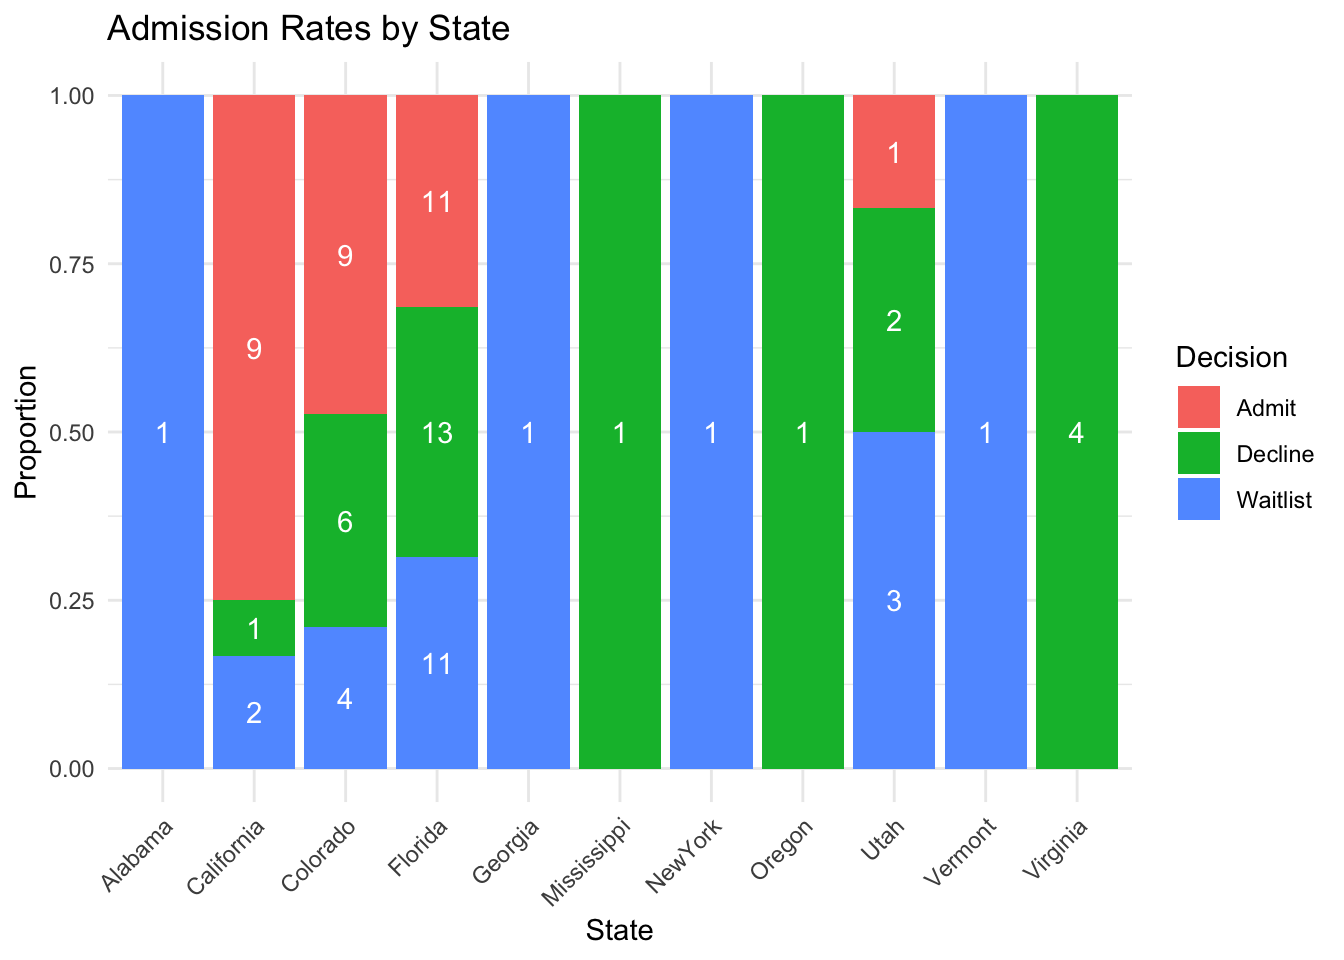

In [ ]:
ggplot(data, aes(x = State, fill = Decision)) +
  geom_bar(position = 'fill') +
  geom_text(aes(label = ..count..), stat = 'count', position = position_fill(vjust = 0.5), color = 'white') +
  labs(title = 'Admission Rates by State', y = 'Proportion', x = 'State') +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

**Analysis:** The visualization highlights which states have higher or lower admission rates. States with consistently low acceptance rates may need targeted recruitment strategies or support programs.

### 2. GPA and Test Scores for Admitted vs. Rejected Students

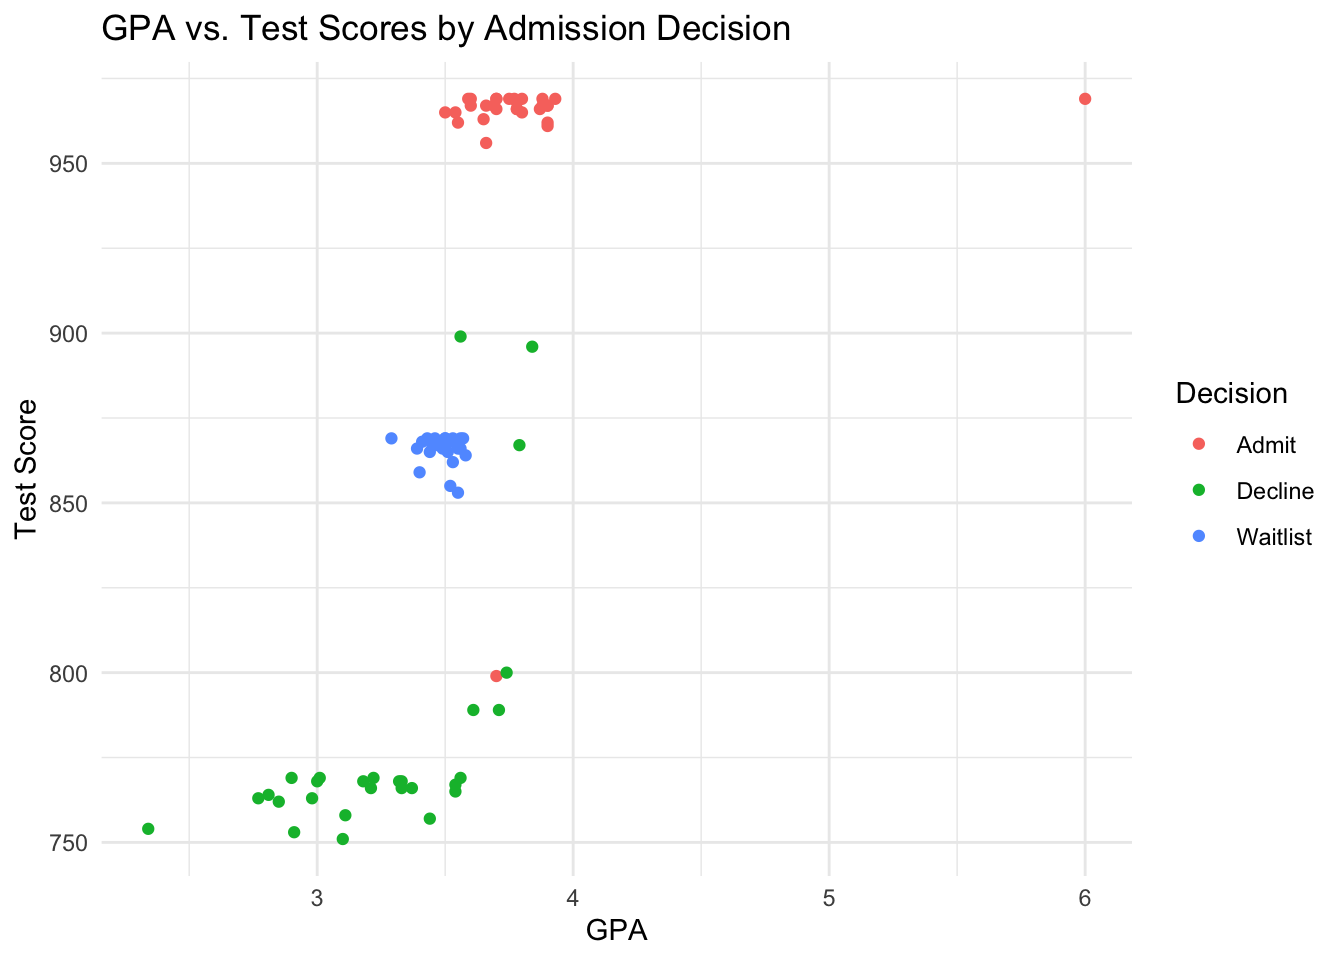

In [ ]:
ggplot(data, aes(x = GPA, y = TestScore, color = Decision)) +
  geom_point() +
  labs(title = 'GPA vs. Test Scores by Admission Decision', x = 'GPA', y = 'Test Score') +
  theme_minimal()

**Analysis:** This scatter plot reveals how GPA and test scores correlate with admissions decisions. Students with higher GPAs and test scores generally have a higher chance of being admitted.

### 3. Correlation Heatmap

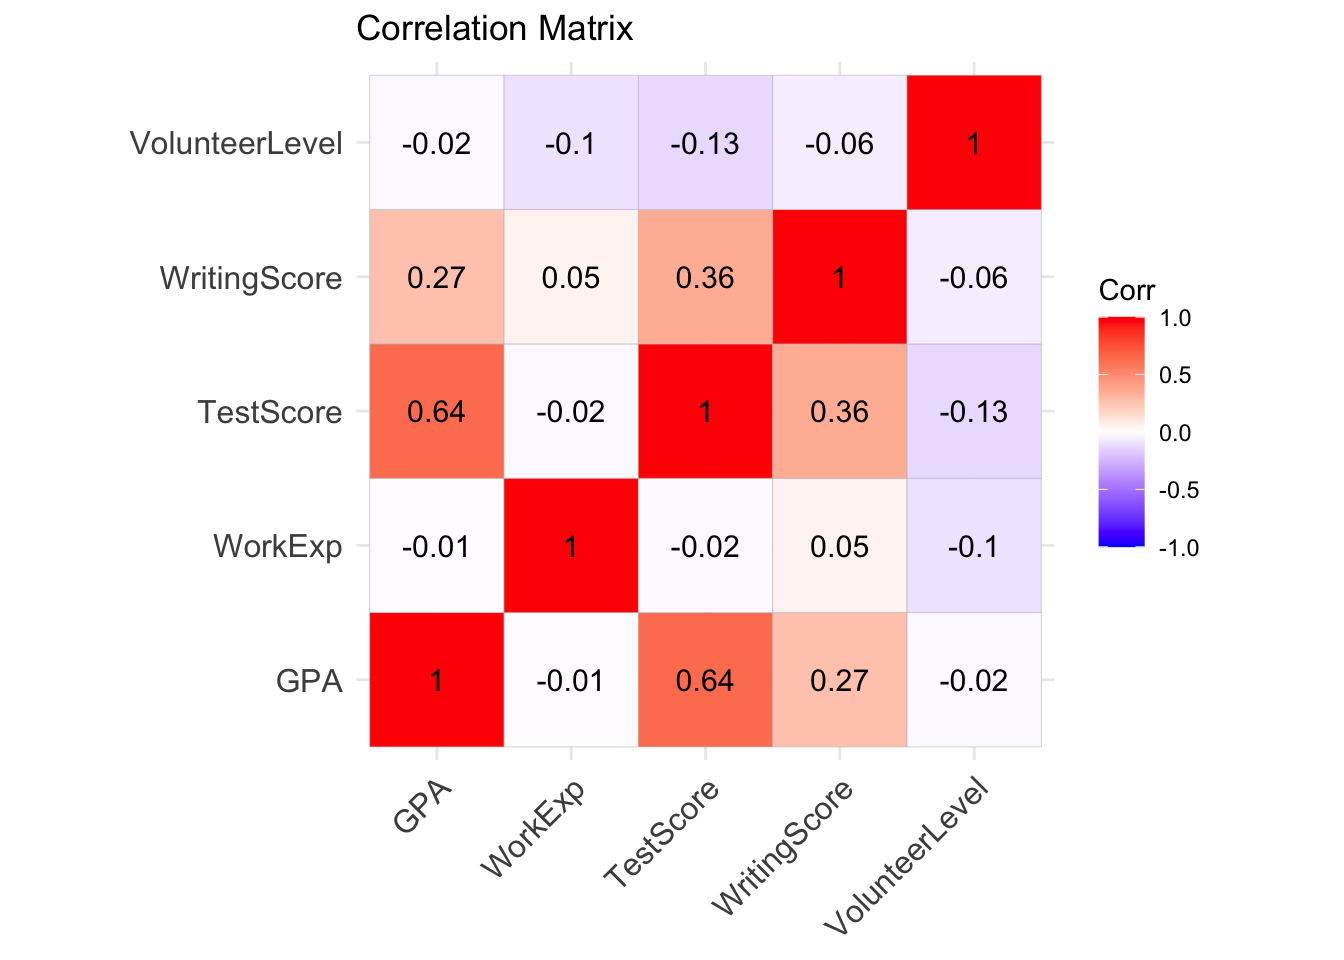

In [ ]:
corr_matrix <- data %>% select(GPA, WorkExp, TestScore, WritingScore, VolunteerLevel) %>% cor()
ggcorrplot(corr_matrix, lab = TRUE, title = 'Correlation Matrix')

**Analysis:** The heatmap shows the correlations between quantitative variables. Strong correlations can help identify which metrics are most predictive of admissions success.

### 4. Boxplot of Voluteer Level Distribution Grouped by Decision

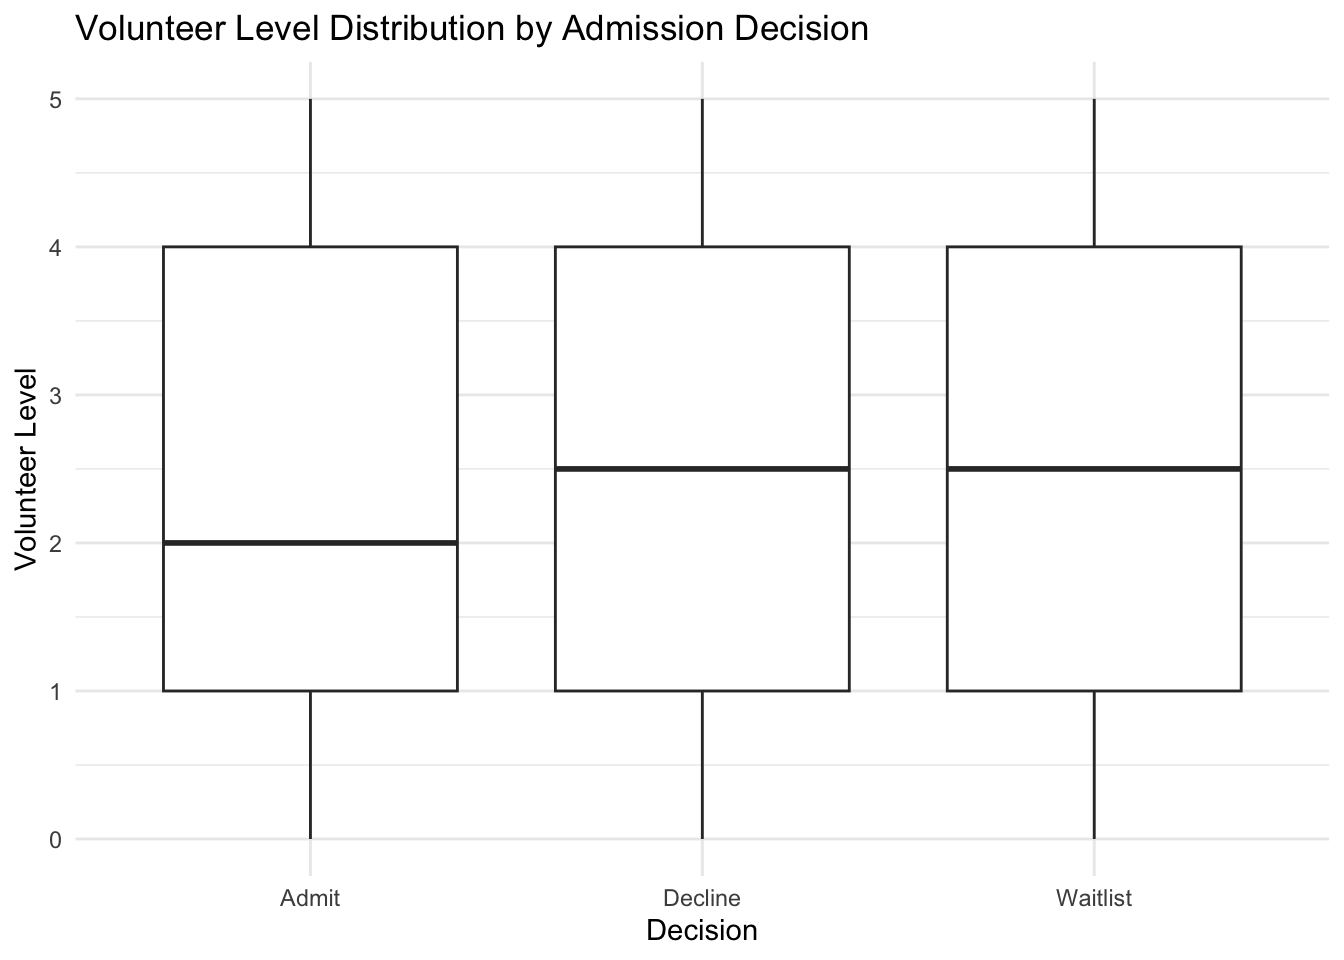

In [ ]:
ggplot(data, aes(x = Decision, y = VolunteerLevel)) +
  geom_boxplot() +
  labs(title = 'Volunteer Level Distribution by Admission Decision', x = 'Decision', y = 'Volunteer Level') +
  theme_minimal()

**Analysis:** This grouped boxplot provides insights into the distribution of admissions criteria.

Key observations include:

-   GPA/ and Admission Relationship: The visualization confirms that applicants with a GPA above a certain threshold (e.g., 3.5) have a significantly higher chance of admission.

-   Test score and Admission Relationship: A sharp increase in acceptance rates is observed in the 900-1000 test score range

-   High writing scores (90-100) improve chances for getting admission

-   Volunteer Experience Impact: it appears to have minimal impact on the final admission decision

## Conclusion

### GPA Impact

1.  High GPAs (3.0-3.5 and 3.5-4.0) have significantly higher acceptance rates, with the 3.5-4.0 range being the strongest predictor of acceptance.
2.  Suggests that academic performance is a critical factor in the admission process.

### Test Scores

1.  A sharp increase in acceptance rates is observed in the 900-1000 test score range.
2.  Emphasizes the importance of standardized testing in the selection process.

### Writing Scores

1.  High writing scores (90-100) improve acceptance chances, but the acceptance rate is still significantly lower compared to other metrics.
2.  Indicates writing score might be a secondary factor or less emphasized compared to GPA and test scores.

### Work Experience

1.  Applicants with less work experience (0-20 years) show higher acceptance rates.
2.  This might indicate a preference for younger applicants or those earlier in their career paths, possibly aligning with program goals targeting recent graduates or early-career professionals.

### Volunteer Level

1.  Volunteer levels do not show a strong correlation with acceptance rates, suggesting this might not be a significant criterion in the current evaluation process.

### Applicant’s Stat

1.  There is a notable geographical impact on acceptance rates, with California having the highest acceptance rate.
2.  States like Alabama, Vermont, and Virginia also show strong acceptance metrics, while other states may need more targeted outreach or support.

## Suggestions for Future Admission Evaluations:

1.  Enhance GPA Weighting: • Maintain or increase the emphasis on academic performance, particularly for applicants with GPAs above 3.0. • Consider adding additional weight to applicants from rigorous academic institutions or challenging coursework.

2.  Reevaluate Work Experience Criteria: • Consider whether the preference for less work experience aligns with program goals. If diversity in professional backgrounds is desired, adjust admission strategies accordingly.

3.  Writing Skills Assessment: • If writing is a critical skill for success in the program, enhance the evaluation of writing samples or essays. Alternatively, if writing scores are not as crucial, streamline this criterion to focus on higher-impact factors.

4.  Volunteer Experience Consideration: • Since volunteer experience does not show a strong influence on acceptance rates, consider de-emphasizing this criterion unless community service is a core value of the institution.

## Marketing Campaign Suggestions:

1.  Target High-Performing Students
    -   Focus outreach efforts on students with high GPAs and strong standardized test scores.
    -   Collaborate with high schools, undergraduate institutions, and tutoring centers to attract these candidates.
2.  Regional Campaigns
    -   Implement targeted marketing in high-acceptance regions such as California, Virginia, and Vermont.
    -   For states with lower acceptance rates, explore potential barriers (e.g., awareness, application support) and address them through localized campaigns.

## Overall Strategy

1.  By focusing on academic excellence and regional strengths, while adjusting evaluation criteria to align with institutional priorities, the admissions team can enhance both the quality and diversity of incoming students.
2.  Simultaneously, targeted and data-driven marketing efforts will ensure that the institution attracts well-qualified applicants and improves overall admission outcomes.